In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [4]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [5]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [6]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/nicte/.keras/datasets/facades'),
 WindowsPath('C:/Users/nicte/.keras/datasets/facades.tar.gz'),
 WindowsPath('C:/Users/nicte/.keras/datasets/fashion-mnist'),
 WindowsPath('C:/Users/nicte/.keras/datasets/mnist.npz')]

In [7]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


Each original image is of size `256 x 512` containing two `256 x 256`

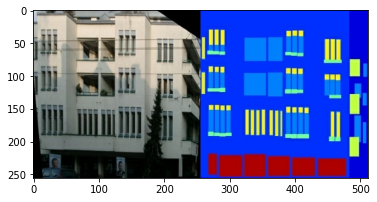

In [8]:
plt.figure()
plt.imshow(sample_image)

In [9]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

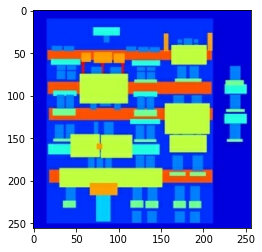

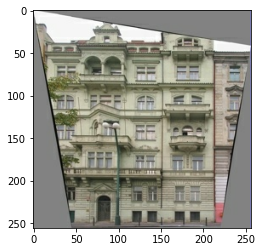

In [10]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, UpSampling2D 
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.optimizers import Adam

### Define the network hyperparameters

In [12]:
optimizer_type = Adam(lr=1e-4)  # optimisation algorithm: Adam 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 500  # maxmimum number of epochs to be iterated
batch_size = 60  # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Define the network architecture

* using the Keras' *functional* model

In [13]:
def create_u_down(input_layer, filters, kernel_size=(4,4), padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(input_layer)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D((2,2), strides=(2,2))(conv)
    return conv, pool

def create_u_up(input_layer, skip_layer, filters, kernel_size=(4,4), padding='same', strides=1):
    up = UpSampling2D((2,2))(input_layer)
    if skip_layer is not None:
        up = concatenate([up, skip_layer], axis=3)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(up)
    conv = BatchNormalization()(conv)
    return conv

def create_u_net_a(input_layer, kernel_size=(4,4), padding='same', strides=1):
    # Encoder
    conv1, pool1 = create_u_down(input_layer, 64, kernel_size, padding, strides)
    conv2, pool2 = create_u_down(pool1, 128, kernel_size, padding, strides)
    conv3, pool3 = create_u_down(pool2, 256, kernel_size, padding, strides)
    conv4, pool4 = create_u_down(pool3, 512, kernel_size, padding, strides)
    conv5, pool5 = create_u_down(pool4, 512, kernel_size, padding, strides)
    conv6, pool6 = create_u_down(pool5, 512, kernel_size, padding, strides)
    conv7, pool7 = create_u_down(pool6, 512, kernel_size, padding, strides)
    conv8, pool8 = create_u_down(pool7, 512, kernel_size, padding, strides)

    # Bridge
    conv9 = Conv2D(512, kernel_size, padding=padding, strides=strides, activation='relu')(pool8)
    conv9 = BatchNormalization()(conv9)

    # Decoder
    conv10 = create_u_up(conv9, conv8, 512, kernel_size, padding, strides)
    conv11 = create_u_up(conv10, conv7, 512, kernel_size, padding, strides)
    conv12 = create_u_up(conv11, conv6, 512, kernel_size, padding, strides)
    conv13 = create_u_up(conv12, conv5, 512, kernel_size, padding, strides)
    conv14 = create_u_up(conv13, conv4, 256, kernel_size, padding, strides)
    conv15 = create_u_up(conv14, conv3, 128, kernel_size, padding, strides)
    conv16 = create_u_up(conv15, conv2, 64, kernel_size, padding, strides)
    
    # Output
    output = UpSampling2D((2,2))(conv16)
    output = Conv2D(3, (4,4), padding=padding, strides=strides, activation='relu')(output)
    return output

def create_u_net_b(input_layer, kernel_size=(4,4), padding='same', strides=1):
    # Encoder
    conv1, pool1 = create_u_down(input_layer, 64, kernel_size, padding, strides)
    conv2, pool2 = create_u_down(pool1, 128, kernel_size, padding, strides)
    conv3, pool3 = create_u_down(pool2, 256, kernel_size, padding, strides)
    conv4, pool4 = create_u_down(pool3, 512, kernel_size, padding, strides)
    conv5, pool5 = create_u_down(pool4, 512, kernel_size, padding, strides)
    conv6, pool6 = create_u_down(pool5, 512, kernel_size, padding, strides)
    conv7, pool7 = create_u_down(pool6, 512, kernel_size, padding, strides)
    conv8, pool8 = create_u_down(pool7, 512, kernel_size, padding, strides)

    # Bridge
    conv9 = Conv2D(512, kernel_size, padding=padding, strides=strides, activation='relu')(pool8)
    conv9 = BatchNormalization()(conv9)

    # Decoder
    conv10 = create_u_up(conv9, conv8, 512, kernel_size, padding, strides)
    conv11 = create_u_up(conv10, None, 512, kernel_size, padding, strides)
    conv12 = create_u_up(conv11, None, 512, kernel_size, padding, strides)
    conv13 = create_u_up(conv12, conv5, 512, kernel_size, padding, strides)
    conv14 = create_u_up(conv13, None, 256, kernel_size, padding, strides)
    conv15 = create_u_up(conv14, None, 128, kernel_size, padding, strides)
    conv16 = create_u_up(conv15, conv2, 64, kernel_size, padding, strides)
    
    # Output
    output = UpSampling2D((2,2))(conv16)
    output = Conv2D(3, (4,4), padding=padding, strides=strides, activation='relu')(output)
    return output

def create_model(model_structure = create_u_net_a):
    input_layer = Input((256, 256, 3))
    output_layer = model_structure(input_layer, strides=1)
    model = Model(input_layer, output_layer)
    model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)
    return model

model_a = create_model(create_u_net_a)
model_a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

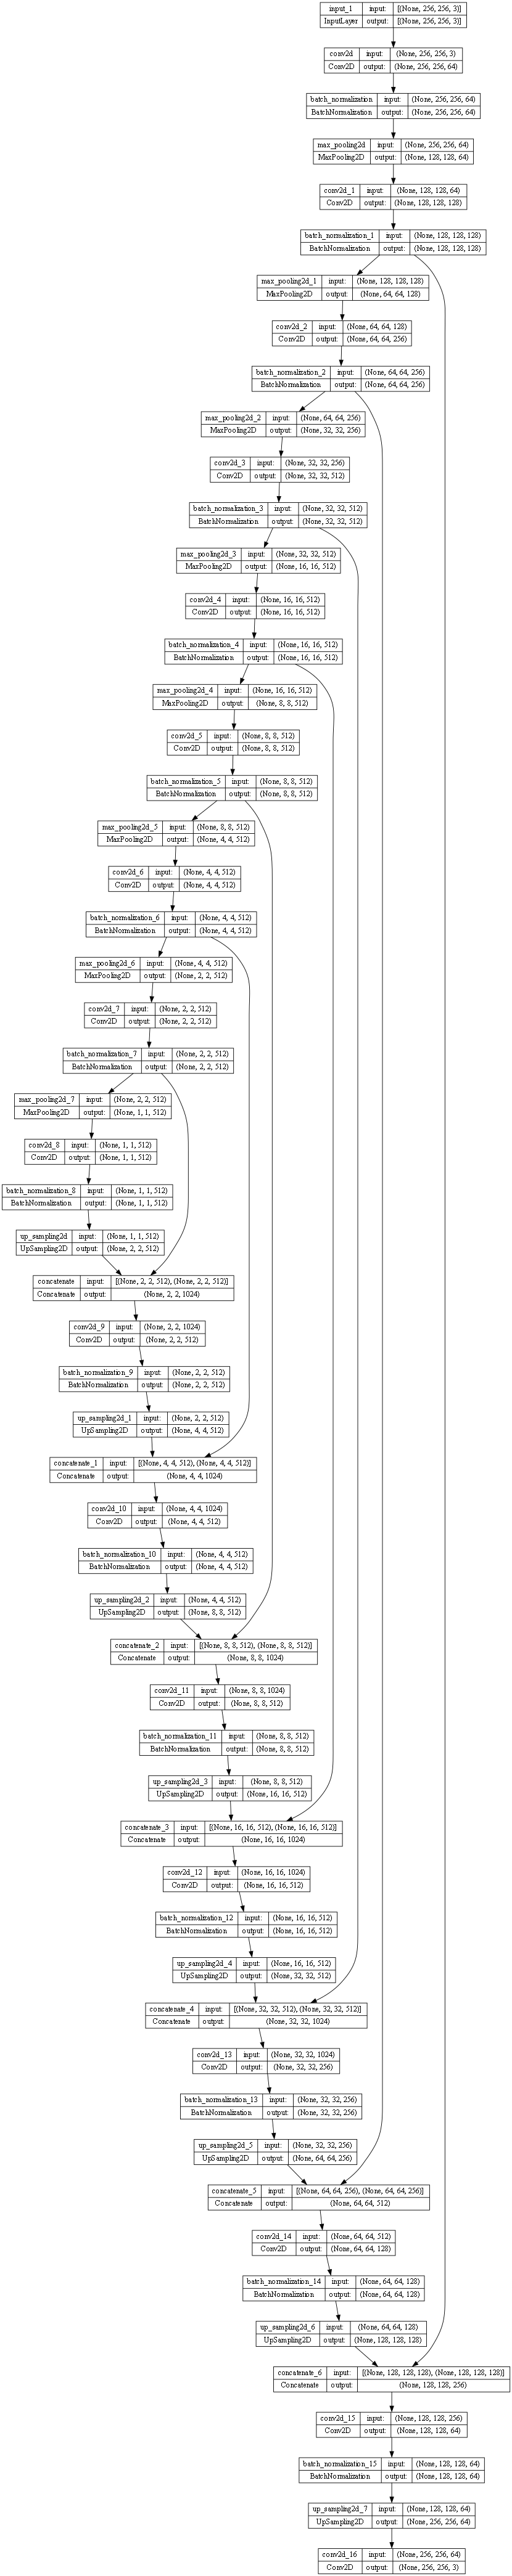

In [14]:
tf.keras.utils.plot_model(model_a, show_shapes=True, dpi=64)

In [14]:
def load_dataset(dataset):
    X = []
    y = []
    for file in dataset:
        inp, re = load(file)
        X.append(inp)
        y.append(re)
    return np.array(X), np.array(y)

training_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
Xtrain, ytrain = load_dataset(training_dataset)
print('training_dataset : ', Xtrain.shape, ytrain.shape)

testing_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
Xtest, ytest = load_dataset(testing_dataset)
print('testing_dataset : ', Xtest.shape, ytest.shape)

validation_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
Xval, yval = load_dataset(validation_dataset)
print('validation_dataset : ', Xval.shape, yval.shape)

training_dataset :  (400, 256, 256, 3) (400, 256, 256, 3)
testing_dataset :  (106, 256, 256, 3) (106, 256, 256, 3)
validation_dataset :  (100, 256, 256, 3) (100, 256, 256, 3)


In [15]:
reduction_ratio = 1
# take only reduction_ratio percent of the training and validation data
Xtrain = Xtrain[:int(Xtrain.shape[0]*reduction_ratio)]
ytrain = ytrain[:int(ytrain.shape[0]*reduction_ratio)]
Xval = Xval[:int(Xval.shape[0]*reduction_ratio)]
yval = yval[:int(yval.shape[0]*reduction_ratio)]

print('training_dataset : ', Xtrain.shape, ytrain.shape)
print('validation_dataset : ', Xval.shape, yval.shape)

training_dataset :  (400, 256, 256, 3) (400, 256, 256, 3)
validation_dataset :  (100, 256, 256, 3) (100, 256, 256, 3)


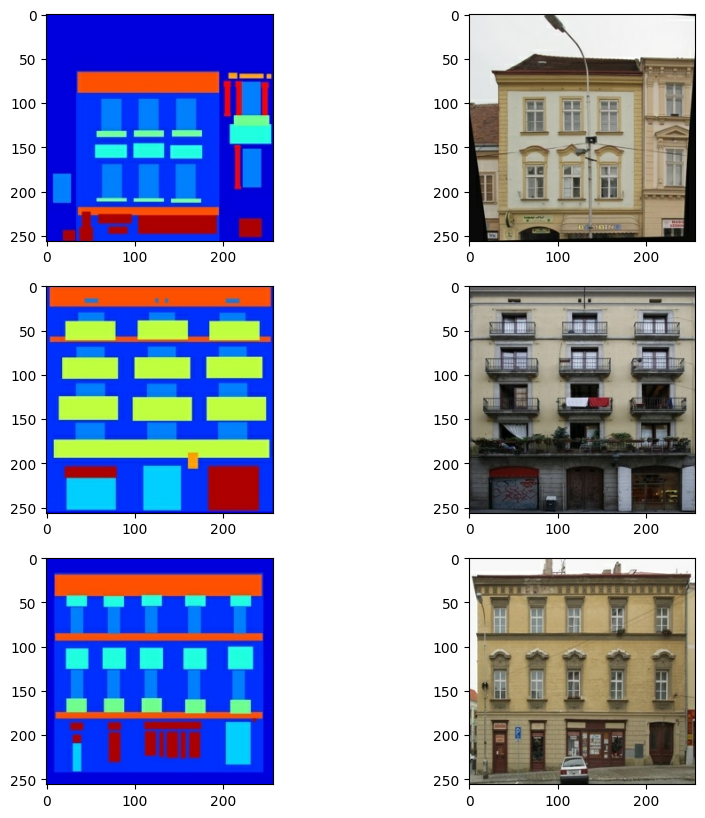

In [16]:
# Plot the first three training image and ground truths

fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i in range(3):
    ax[i, 0].imshow(Xtrain[i] / 255)
    ax[i, 1].imshow(ytrain[i] / 255)
    
plt.show()

In [17]:
# train the model
history_a = model_a.fit(Xtrain, ytrain, epochs=max_epochs, batch_size=batch_size, validation_data=(Xval, yval))

Epoch 1/500
7/7 [==============================] - 36s 2s/step - loss: 16406.6758 - mean_absolute_error: 112.4697 - val_loss: 16146.2217 - val_mean_absolute_error: 112.1119
Epoch 2/500
7/7 [==============================] - 2s 253ms/step - loss: 16139.2012 - mean_absolute_error: 111.5231 - val_loss: 14227.6172 - val_mean_absolute_error: 104.2340
Epoch 3/500
7/7 [==============================] - 2s 252ms/step - loss: 15980.8887 - mean_absolute_error: 111.0205 - val_loss: 11963.0283 - val_mean_absolute_error: 94.0716
Epoch 4/500
7/7 [==============================] - 2s 250ms/step - loss: 15822.1074 - mean_absolute_error: 110.4906 - val_loss: 13142.7949 - val_mean_absolute_error: 99.6308
Epoch 5/500
7/7 [==============================] - 2s 251ms/step - loss: 15684.7129 - mean_absolute_error: 109.9720 - val_loss: 12921.9902 - val_mean_absolute_error: 98.6578
Epoch 6/500
7/7 [==============================] - 2s 252ms/step - loss: 15552.5596 - mean_absolute_error: 109.4697 - val_loss: 13

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


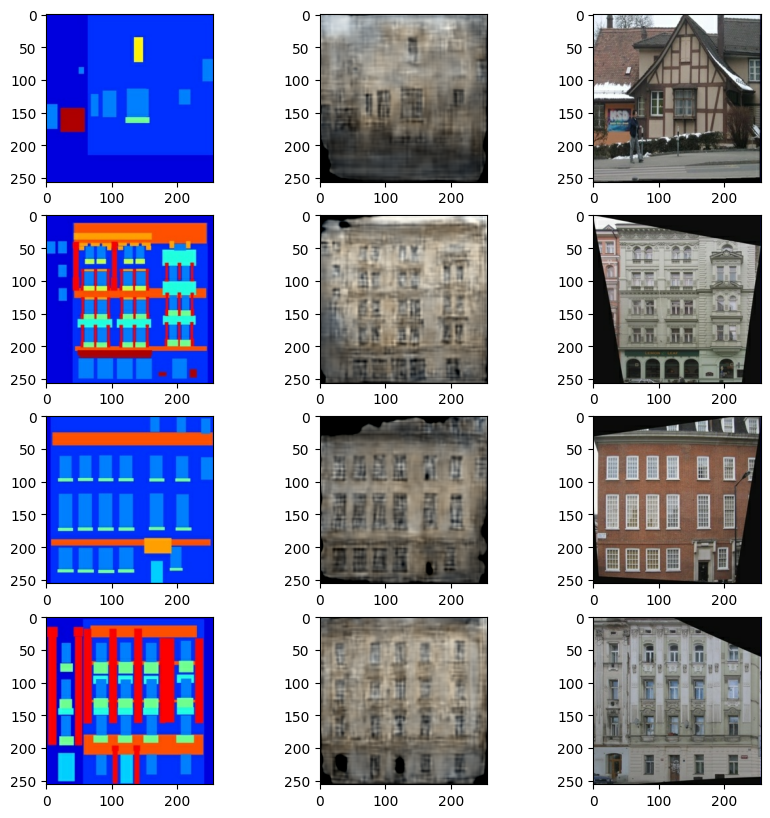

In [18]:
# Display, test image, prediction and groung trith image
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    ax[i, 0].imshow(Xtest[i] / 255)
    ax[i, 1].imshow(model_a.predict(Xtest[i:i+1])[0] / 255)
    ax[i, 2].imshow(ytest[i] / 255)

plt.show()

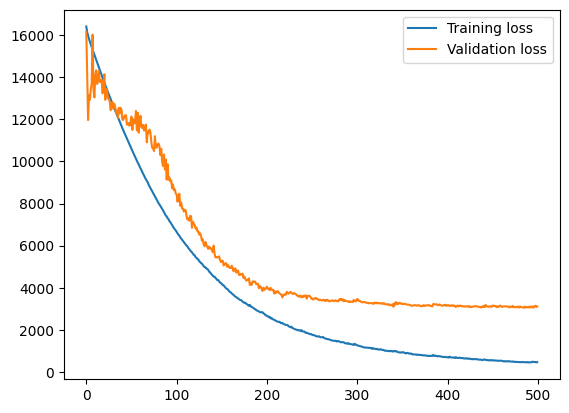

In [19]:
# Plot the training and validation loss
plt.plot(history_a.history['loss'], label='Training loss')
plt.plot(history_a.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [20]:
# Save the model
model_a.save('model_a.h5')


In [21]:
# load model a
from tensorflow.keras.models import load_model

model_a = load_model('model_a.h5')

In [15]:
model_b = create_model(create_u_net_b)
model_b.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 64  3136        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_17[0][0]']              
 ormalization)                  )                                                           

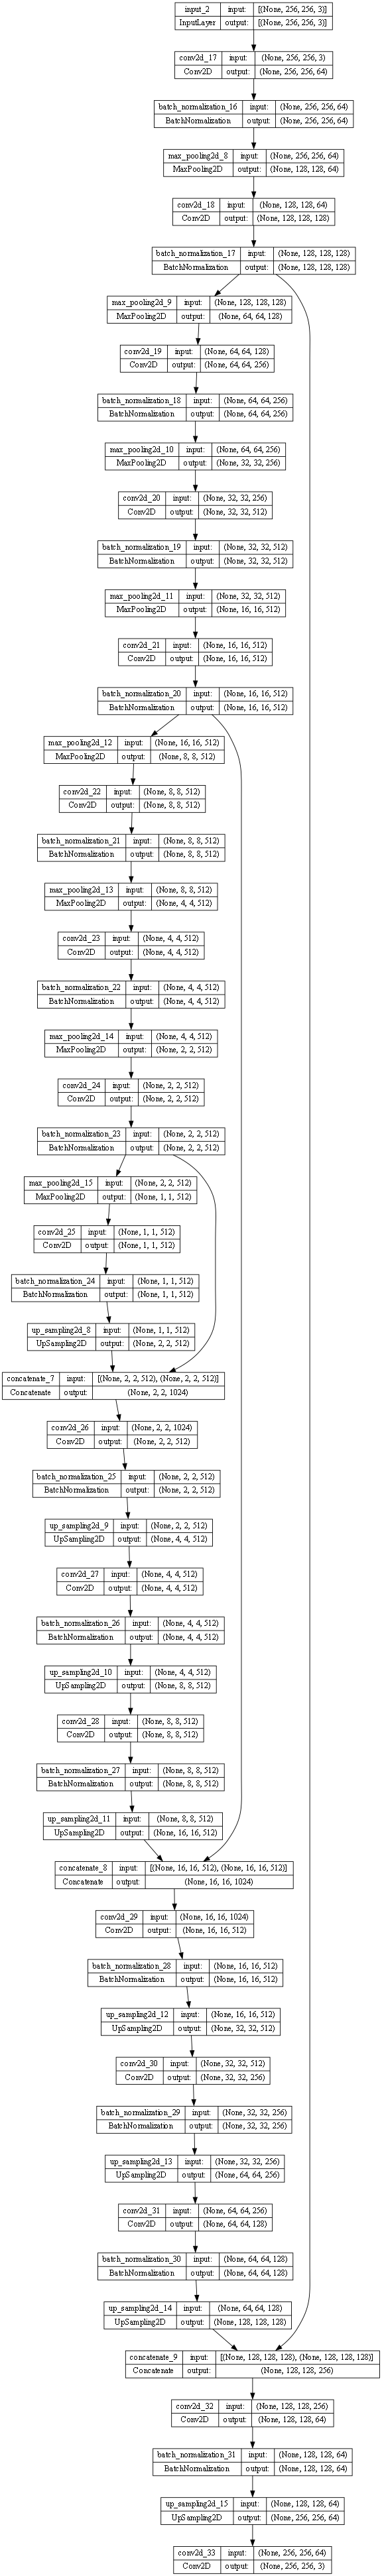

In [17]:
tf.keras.utils.plot_model(model_b, show_shapes=True, dpi=64)

In [23]:
# train the model
history_b = model_b.fit(Xtrain, ytrain, epochs=max_epochs, batch_size=batch_size, validation_data=(Xval, yval))


Epoch 1/500
7/7 [==============================] - 8s 549ms/step - loss: 16223.1426 - mean_absolute_error: 111.6782 - val_loss: 897926.0000 - val_mean_absolute_error: 549.7772
Epoch 2/500
7/7 [==============================] - 2s 227ms/step - loss: 15669.9746 - mean_absolute_error: 109.4219 - val_loss: 15301678.0000 - val_mean_absolute_error: 1788.1106
Epoch 3/500
7/7 [==============================] - 2s 228ms/step - loss: 15142.2998 - mean_absolute_error: 107.2419 - val_loss: 8636864.0000 - val_mean_absolute_error: 1359.2629
Epoch 4/500
7/7 [==============================] - 2s 229ms/step - loss: 14613.4248 - mean_absolute_error: 105.1201 - val_loss: 24210160.0000 - val_mean_absolute_error: 2836.2031
Epoch 5/500
7/7 [==============================] - 2s 226ms/step - loss: 14135.9287 - mean_absolute_error: 103.0153 - val_loss: 102414400.0000 - val_mean_absolute_error: 5432.2910
Epoch 6/500
7/7 [==============================] - 2s 226ms/step - loss: 13722.3066 - mean_absolute_error: 1

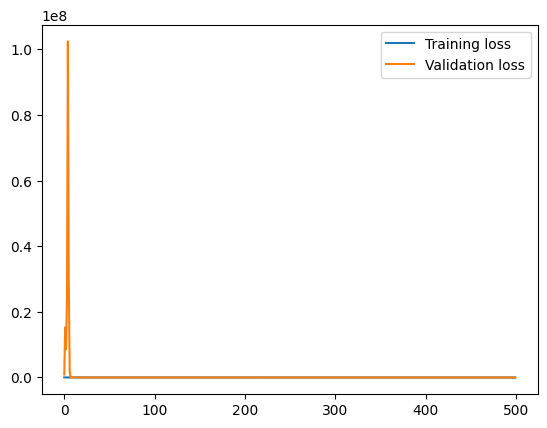

In [24]:
# Plot the training and validation loss
plt.plot(history_b.history['loss'], label='Training loss')
plt.plot(history_b.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [25]:
# Save the model
model_b.save('model_b.h5')

In [26]:
# load model b

model_b = load_model('model_b.h5')

1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


IndexError: ignored

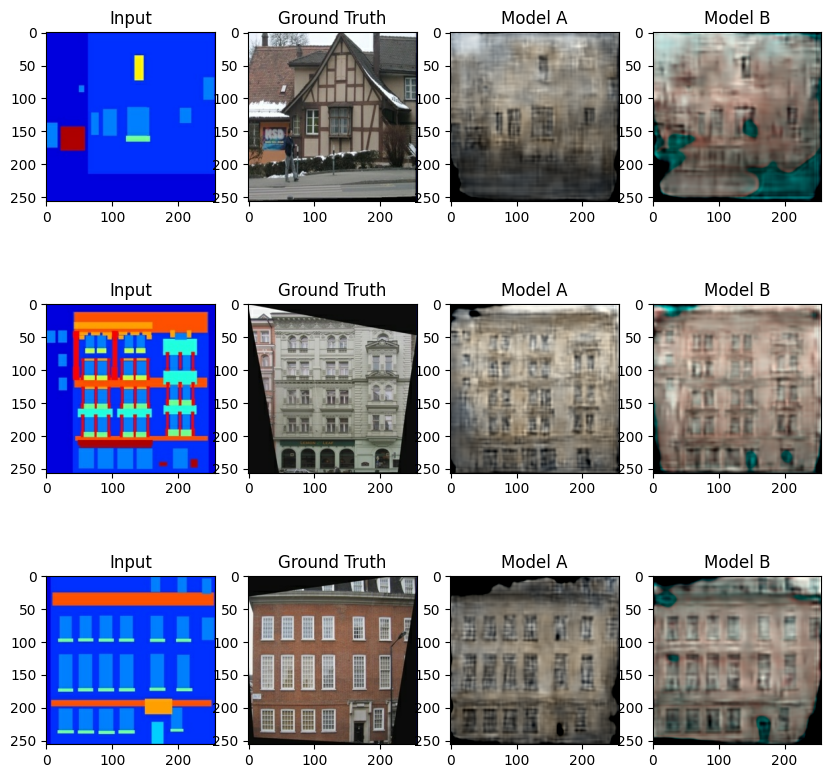

In [27]:
# For four testing images, show the ground truth, the prediction and the two model predictions

fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    ax[i, 0].imshow(Xtest[i] / 255)
    ax[i, 0].set_title('Input')

    ax[i, 1].imshow(ytest[i] / 255)
    ax[i, 1].set_title('Ground Truth')

    ax[i, 2].imshow(model_a.predict(Xtest[i:i+1])[0] / 255)
    ax[i, 2].set_title('Model A')

    ax[i, 3].imshow(model_b.predict(Xtest[i:i+1])[0] / 255)
    ax[i, 3].set_title('Model B')

plt.show()